# Baseline Results for Multi-modal Approaches

In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 

from pathlib import Path
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed, Conv1D,  MaxPooling1D, ConvLSTM1D
from tensorflow.keras import models

In [19]:
accuracies = []
aucs = []
model_names = ['M1.1 CNN+LSTM', 'M1.1 ConvLSTM', 'M1.2 CNN+LSTM', 'M1.2 ConvLSTM']

In [20]:
def load_file(file, prediction_type):
    df = pd.read_csv(file, header=0)
    labels = df[prediction_type]
    df = df.drop(columns=['pain_area', 'pain_level'])
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df.to_numpy(), labels

def load_dataset(input_filepath, prediction_type, modality):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file, prediction_type)
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file, prediction_type)
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

## 1. Early Fusion - Fusion is performed at feature level

Early fusion concatenates features at the input level, then all the work is on the classifier. 

My initial assumption is that perhaps early fusion is not a good idea because face modality is missing about half the times?

### 1.1 Pain area prediction

#### Concatenate datasets (fusion stage)

In [21]:
def apply_early_fusion(input_filepath, prediction_type):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    body_train_filepath = data_dir / input_filepath / 'train' / 'skeleton'
    body_test_filepath = data_dir / input_filepath / 'test' / 'skeleton'
    face_train_filepath = data_dir / input_filepath / 'train' / 'AUs'
    face_test_filepath = data_dir / input_filepath / 'test' / 'AUs'
    # 1. Load train data
    X = list()
    y = list()
    for file in body_train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file, prediction_type)
            has_equivalent_face_file = False
            for second_file in face_train_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file, prediction_type)
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                # Add null values to the face features
                full_X = np.concatenate((body_x, np.zeros((body_x.shape[0], 10))), axis=1)
                X.append(full_X)
                y.append(body_labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in body_test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file, prediction_type)
            has_equivalent_face_file = False
            for second_file in face_test_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file, prediction_type)
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                # Add null values to the face features
                full_X = np.concatenate((body_x, np.zeros((body_x.shape[0], 10))), axis=1)
                X.append(full_X)
                y.append(body_labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

In [22]:
X_train, X_test, y_train, y_test = apply_early_fusion('processed', 'pain_area')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 350, 48) (534, 5)
(81, 1, 350, 48) (81, 5)


#### Train CNN+LSTM Model (from uni-modal architectures)

In [23]:
epochs, batch_size = 50, 68
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [24]:
def get_CNN_model(n_features, n_length, n_outputs):
    model = models.Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3,
        activation='relu'), input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first')))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, verbose=2)
    return history

In [25]:
early_fusion_model = get_CNN_model(n_features, n_length, n_outputs)
early_fusion_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, None, 348, 64)    9280      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, None, 348, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, None, 11136)      0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 100)               4494800   
                                                                 
 dense_16 (Dense)            (None, 100)               10100     
                                                     

Epoch 1/50
6/6 - 2s - loss: 1.5301 - accuracy: 0.3258 - auc_9: 0.6243 - val_loss: 1.3997 - val_accuracy: 0.5337 - val_auc_9: 0.7037 - 2s/epoch - 367ms/step
Epoch 2/50
6/6 - 0s - loss: 1.3064 - accuracy: 0.5702 - auc_9: 0.7605 - val_loss: 1.2954 - val_accuracy: 0.5337 - val_auc_9: 0.8062 - 385ms/epoch - 64ms/step
Epoch 3/50
6/6 - 0s - loss: 1.2431 - accuracy: 0.5702 - auc_9: 0.8053 - val_loss: 1.2581 - val_accuracy: 0.5337 - val_auc_9: 0.7992 - 346ms/epoch - 58ms/step
Epoch 4/50
6/6 - 0s - loss: 1.2131 - accuracy: 0.5702 - auc_9: 0.8056 - val_loss: 1.2355 - val_accuracy: 0.5337 - val_auc_9: 0.7992 - 347ms/epoch - 58ms/step
Epoch 5/50
6/6 - 0s - loss: 1.1977 - accuracy: 0.5702 - auc_9: 0.8057 - val_loss: 1.2251 - val_accuracy: 0.5337 - val_auc_9: 0.7992 - 343ms/epoch - 57ms/step
Epoch 6/50
6/6 - 0s - loss: 1.1915 - accuracy: 0.5702 - auc_9: 0.8045 - val_loss: 1.2193 - val_accuracy: 0.5337 - val_auc_9: 0.7992 - 344ms/epoch - 57ms/step
Epoch 7/50
6/6 - 0s - loss: 1.1881 - accuracy: 0.5702 

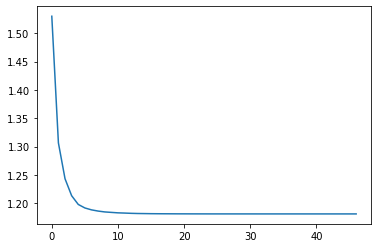

Epoch 1/50
6/6 - 2s - loss: 1.4505 - accuracy: 0.4860 - auc_10: 0.6803 - val_loss: 1.2610 - val_accuracy: 0.5787 - val_auc_10: 0.8034 - 2s/epoch - 380ms/step
Epoch 2/50
6/6 - 0s - loss: 1.2787 - accuracy: 0.5478 - auc_10: 0.7958 - val_loss: 1.2352 - val_accuracy: 0.5787 - val_auc_10: 0.8090 - 343ms/epoch - 57ms/step
Epoch 3/50
6/6 - 0s - loss: 1.2495 - accuracy: 0.5478 - auc_10: 0.8007 - val_loss: 1.2032 - val_accuracy: 0.5787 - val_auc_10: 0.8090 - 340ms/epoch - 57ms/step
Epoch 4/50
6/6 - 0s - loss: 1.2279 - accuracy: 0.5478 - auc_10: 0.7979 - val_loss: 1.1882 - val_accuracy: 0.5787 - val_auc_10: 0.8090 - 344ms/epoch - 57ms/step
Epoch 5/50
6/6 - 0s - loss: 1.2166 - accuracy: 0.5478 - auc_10: 0.8018 - val_loss: 1.1819 - val_accuracy: 0.5787 - val_auc_10: 0.8090 - 339ms/epoch - 57ms/step
Epoch 6/50
6/6 - 0s - loss: 1.2111 - accuracy: 0.5478 - auc_10: 0.8002 - val_loss: 1.1783 - val_accuracy: 0.5787 - val_auc_10: 0.8090 - 341ms/epoch - 57ms/step
Epoch 7/50
6/6 - 0s - loss: 1.2077 - accur

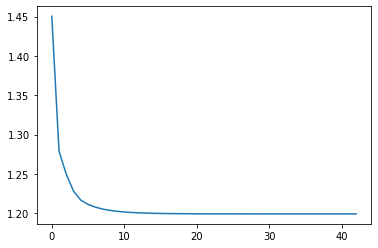

Epoch 1/50
6/6 - 3s - loss: 1.4020 - accuracy: 0.5197 - auc_11: 0.7375 - val_loss: 1.2869 - val_accuracy: 0.5618 - val_auc_11: 0.7892 - 3s/epoch - 450ms/step
Epoch 2/50
6/6 - 0s - loss: 1.2591 - accuracy: 0.5562 - auc_11: 0.8045 - val_loss: 1.2350 - val_accuracy: 0.5618 - val_auc_11: 0.7963 - 322ms/epoch - 54ms/step
Epoch 3/50
6/6 - 0s - loss: 1.2192 - accuracy: 0.5562 - auc_11: 0.8059 - val_loss: 1.2166 - val_accuracy: 0.5618 - val_auc_11: 0.7963 - 325ms/epoch - 54ms/step
Epoch 4/50
6/6 - 0s - loss: 1.2024 - accuracy: 0.5562 - auc_11: 0.8077 - val_loss: 1.2086 - val_accuracy: 0.5618 - val_auc_11: 0.7962 - 324ms/epoch - 54ms/step
Epoch 5/50
6/6 - 0s - loss: 1.1951 - accuracy: 0.5562 - auc_11: 0.8049 - val_loss: 1.2040 - val_accuracy: 0.5618 - val_auc_11: 0.7961 - 332ms/epoch - 55ms/step
Epoch 6/50
6/6 - 0s - loss: 1.1896 - accuracy: 0.5562 - auc_11: 0.8070 - val_loss: 1.2021 - val_accuracy: 0.5618 - val_auc_11: 0.7962 - 328ms/epoch - 55ms/step
Epoch 7/50
6/6 - 0s - loss: 1.1872 - accur

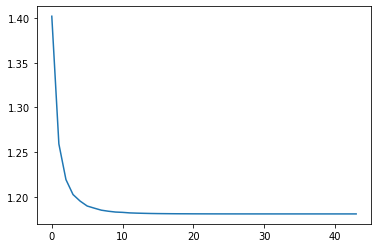

In [26]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    early_fusion_model = get_CNN_model(n_features, n_length, n_outputs)
    history = train(early_fusion_model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Evaluate early fusion performance

In [27]:
loss, accuracy, auc = early_fusion_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 50.617%

AUC: 0.7994


#### Train Convolutional LSTM Model (from uni-modal architectures)

In [28]:
def get_convLSTM_model(n_features, n_length, n_outputs):
    model = models.Sequential()
    model.add(ConvLSTM1D(filters=64, kernel_size=(3), activation='relu', input_shape=(None, n_length, n_features)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, verbose=2)
    return history

In [29]:
early_fusion_model = get_convLSTM_model(n_features, n_length, n_outputs)
early_fusion_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d_4 (ConvLSTM1D)  (None, 348, 64)           86272     
                                                                 
 flatten_12 (Flatten)        (None, 22272)             0         
                                                                 
 dense_24 (Dense)            (None, 100)               2227300   
                                                                 
 dense_25 (Dense)            (None, 5)                 505       
                                                                 
Total params: 2,314,077
Trainable params: 2,314,077
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
4/4 - 3s - loss: 341.6201 - accuracy: 0.2616 - auc_13: 0.5409 - val_loss: 183.2360 - val_accuracy: 0.5966 - val_auc_13: 0.7479 - 3s/epoch - 739ms/step
Epoch 2/50
4/4 - 1s - loss: 175.4430 - accuracy: 0.5359 - auc_13: 0.7099 - val_loss: 42.2193 - val_accuracy: 0.5126 - val_auc_13: 0.7028 - 630ms/epoch - 158ms/step
Epoch 3/50
4/4 - 1s - loss: 47.7717 - accuracy: 0.3291 - auc_13: 0.5938 - val_loss: 30.9996 - val_accuracy: 0.3277 - val_auc_13: 0.5822 - 682ms/epoch - 170ms/step
Epoch 4/50
4/4 - 1s - loss: 26.1506 - accuracy: 0.3165 - auc_13: 0.5805 - val_loss: 14.9871 - val_accuracy: 0.5630 - val_auc_13: 0.7377 - 640ms/epoch - 160ms/step
Epoch 5/50
4/4 - 1s - loss: 13.2904 - accuracy: 0.5232 - auc_13: 0.7074 - val_loss: 5.2704 - val_accuracy: 0.5294 - val_auc_13: 0.7453 - 625ms/epoch - 156ms/step
Epoch 6/50
4/4 - 1s - loss: 5.8854 - accuracy: 0.3080 - auc_13: 0.6364 - val_loss: 3.3246 - val_accuracy: 0.2521 - val_auc_13: 0.6355 - 636ms/epoch - 159ms/step
Epoch 7/50
4/4 - 1s - los

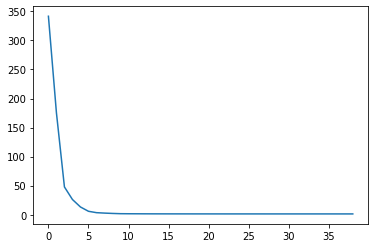

Epoch 1/50
4/4 - 3s - loss: 134.5203 - accuracy: 0.3629 - auc_14: 0.6110 - val_loss: 32.5937 - val_accuracy: 0.2101 - val_auc_14: 0.5477 - 3s/epoch - 738ms/step
Epoch 2/50
4/4 - 1s - loss: 17.7381 - accuracy: 0.4810 - auc_14: 0.6750 - val_loss: 3.5273 - val_accuracy: 0.3950 - val_auc_14: 0.6096 - 624ms/epoch - 156ms/step
Epoch 3/50
4/4 - 1s - loss: 2.0277 - accuracy: 0.2700 - auc_14: 0.5854 - val_loss: 1.6575 - val_accuracy: 0.0588 - val_auc_14: 0.4904 - 619ms/epoch - 155ms/step
Epoch 4/50
4/4 - 1s - loss: 1.5771 - accuracy: 0.4219 - auc_14: 0.5547 - val_loss: 1.6146 - val_accuracy: 0.5210 - val_auc_14: 0.7114 - 618ms/epoch - 155ms/step
Epoch 5/50
4/4 - 1s - loss: 1.5914 - accuracy: 0.5612 - auc_14: 0.7323 - val_loss: 1.6089 - val_accuracy: 0.5210 - val_auc_14: 0.7093 - 627ms/epoch - 157ms/step
Epoch 6/50
4/4 - 1s - loss: 1.5844 - accuracy: 0.5654 - auc_14: 0.7312 - val_loss: 1.6058 - val_accuracy: 0.5210 - val_auc_14: 0.6889 - 616ms/epoch - 154ms/step
Epoch 7/50
4/4 - 1s - loss: 1.581

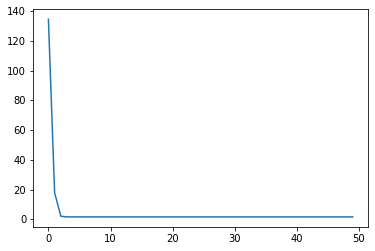

Epoch 1/50
4/4 - 3s - loss: 169.8291 - accuracy: 0.3403 - auc_15: 0.5931 - val_loss: 65.6977 - val_accuracy: 0.3983 - val_auc_15: 0.6539 - 3s/epoch - 837ms/step
Epoch 2/50
4/4 - 1s - loss: 99.6512 - accuracy: 0.4370 - auc_15: 0.6630 - val_loss: 102.0558 - val_accuracy: 0.0678 - val_auc_15: 0.4220 - 624ms/epoch - 156ms/step
Epoch 3/50
4/4 - 1s - loss: 46.4775 - accuracy: 0.4076 - auc_15: 0.6289 - val_loss: 10.7793 - val_accuracy: 0.5254 - val_auc_15: 0.7021 - 611ms/epoch - 153ms/step
Epoch 4/50
4/4 - 1s - loss: 6.3956 - accuracy: 0.5210 - auc_15: 0.7600 - val_loss: 3.4128 - val_accuracy: 0.2373 - val_auc_15: 0.6571 - 612ms/epoch - 153ms/step
Epoch 5/50
4/4 - 1s - loss: 2.4781 - accuracy: 0.3109 - auc_15: 0.6953 - val_loss: 1.4956 - val_accuracy: 0.3051 - val_auc_15: 0.6921 - 611ms/epoch - 153ms/step
Epoch 6/50
4/4 - 1s - loss: 1.5123 - accuracy: 0.2899 - auc_15: 0.6821 - val_loss: 1.5183 - val_accuracy: 0.2712 - val_auc_15: 0.6486 - 602ms/epoch - 150ms/step
Epoch 7/50
4/4 - 1s - loss: 1

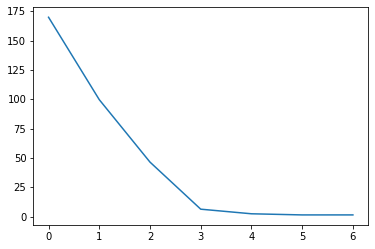

In [30]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    early_fusion_model = get_convLSTM_model(n_features, n_length, n_outputs)
    history = train(early_fusion_model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [31]:
loss, accuracy, auc = early_fusion_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 20.988%

AUC: 0.6236


### 1.2 Pain level prediction

#### Concatenate datasets (fusion stage)

In [32]:
X_train, X_test, y_train, y_test = apply_early_fusion('processed', 'pain_level')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 350, 48) (534, 3)
(81, 1, 350, 48) (81, 3)


#### Train CNN+LSTM Model (from uni-modal architectures)

In [33]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [34]:
early_fusion_model = get_CNN_model(n_features, n_length, n_outputs)
early_fusion_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, None, 348, 64)    9280      
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, None, 348, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, None, 11136)      0         
 stributed)                                                      
                                                                 
 lstm_8 (LSTM)               (None, 100)               4494800   
                                                                 
 dense_32 (Dense)            (None, 100)               10100     
                                                     

Epoch 1/50
6/6 - 3s - loss: 0.9255 - accuracy: 0.5393 - auc_17: 0.7611 - val_loss: 0.7937 - val_accuracy: 0.6629 - val_auc_17: 0.8174 - 3s/epoch - 461ms/step
Epoch 2/50
6/6 - 0s - loss: 0.7833 - accuracy: 0.6320 - auc_17: 0.8040 - val_loss: 0.7559 - val_accuracy: 0.6629 - val_auc_17: 0.8156 - 361ms/epoch - 60ms/step
Epoch 3/50
6/6 - 0s - loss: 0.7508 - accuracy: 0.6320 - auc_17: 0.8053 - val_loss: 0.7444 - val_accuracy: 0.6629 - val_auc_17: 0.8165 - 380ms/epoch - 63ms/step
Epoch 4/50
6/6 - 0s - loss: 0.7371 - accuracy: 0.6320 - auc_17: 0.8026 - val_loss: 0.7421 - val_accuracy: 0.6629 - val_auc_17: 0.8165 - 383ms/epoch - 64ms/step
Epoch 5/50
6/6 - 0s - loss: 0.7303 - accuracy: 0.6320 - auc_17: 0.8092 - val_loss: 0.7401 - val_accuracy: 0.6629 - val_auc_17: 0.8165 - 362ms/epoch - 60ms/step
Epoch 6/50
6/6 - 0s - loss: 0.7271 - accuracy: 0.6320 - auc_17: 0.8049 - val_loss: 0.7426 - val_accuracy: 0.6629 - val_auc_17: 0.8165 - 452ms/epoch - 75ms/step
Epoch 7/50
6/6 - 0s - loss: 0.7257 - accur

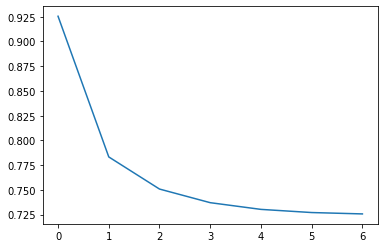

Epoch 1/50
6/6 - 3s - loss: 1.1356 - accuracy: 0.5197 - auc_18: 0.5868 - val_loss: 0.9793 - val_accuracy: 0.6292 - val_auc_18: 0.6349 - 3s/epoch - 429ms/step
Epoch 2/50
6/6 - 0s - loss: 0.8950 - accuracy: 0.6489 - auc_18: 0.7318 - val_loss: 0.8487 - val_accuracy: 0.6292 - val_auc_18: 0.8100 - 348ms/epoch - 58ms/step
Epoch 3/50
6/6 - 0s - loss: 0.8166 - accuracy: 0.6489 - auc_18: 0.8142 - val_loss: 0.7901 - val_accuracy: 0.6292 - val_auc_18: 0.8118 - 354ms/epoch - 59ms/step
Epoch 4/50
6/6 - 0s - loss: 0.7847 - accuracy: 0.6489 - auc_18: 0.8087 - val_loss: 0.7637 - val_accuracy: 0.6292 - val_auc_18: 0.8100 - 361ms/epoch - 60ms/step
Epoch 5/50
6/6 - 0s - loss: 0.7694 - accuracy: 0.6489 - auc_18: 0.8115 - val_loss: 0.7604 - val_accuracy: 0.6292 - val_auc_18: 0.8118 - 350ms/epoch - 58ms/step
Epoch 6/50
6/6 - 0s - loss: 0.7658 - accuracy: 0.6489 - auc_18: 0.8096 - val_loss: 0.7523 - val_accuracy: 0.6292 - val_auc_18: 0.8118 - 361ms/epoch - 60ms/step
Epoch 7/50
6/6 - 0s - loss: 0.7611 - accur

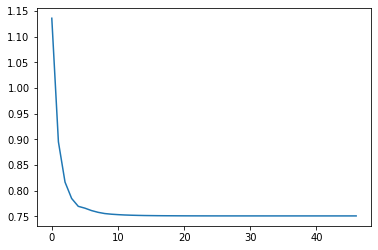

Epoch 1/50
6/6 - 3s - loss: 1.0373 - accuracy: 0.3202 - auc_19: 0.6165 - val_loss: 0.9161 - val_accuracy: 0.6348 - val_auc_19: 0.8080 - 3s/epoch - 464ms/step
Epoch 2/50
6/6 - 0s - loss: 0.8835 - accuracy: 0.6461 - auc_19: 0.8085 - val_loss: 0.8451 - val_accuracy: 0.6348 - val_auc_19: 0.8030 - 432ms/epoch - 72ms/step
Epoch 3/50
6/6 - 0s - loss: 0.8096 - accuracy: 0.6461 - auc_19: 0.8205 - val_loss: 0.7909 - val_accuracy: 0.6348 - val_auc_19: 0.8062 - 406ms/epoch - 68ms/step
Epoch 4/50
6/6 - 0s - loss: 0.7723 - accuracy: 0.6461 - auc_19: 0.8190 - val_loss: 0.7801 - val_accuracy: 0.6348 - val_auc_19: 0.8062 - 430ms/epoch - 72ms/step
Epoch 5/50
6/6 - 0s - loss: 0.7629 - accuracy: 0.6461 - auc_19: 0.8085 - val_loss: 0.7738 - val_accuracy: 0.6348 - val_auc_19: 0.8079 - 385ms/epoch - 64ms/step
Epoch 6/50
6/6 - 0s - loss: 0.7561 - accuracy: 0.6461 - auc_19: 0.8165 - val_loss: 0.7691 - val_accuracy: 0.6348 - val_auc_19: 0.8079 - 333ms/epoch - 55ms/step
Epoch 7/50
6/6 - 0s - loss: 0.7527 - accur

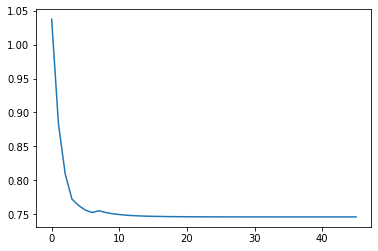

In [35]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    early_fusion_model = get_CNN_model(n_features, n_length, n_outputs)
    history = train(early_fusion_model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [36]:
loss, accuracy, auc = early_fusion_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 77.778%

AUC: 0.8704


#### Train Convolutional LSTM Model (from uni-modal architectures)

In [37]:
early_fusion_model = get_convLSTM_model(n_features, n_length, n_outputs)
early_fusion_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d_8 (ConvLSTM1D)  (None, 348, 64)           86272     
                                                                 
 flatten_20 (Flatten)        (None, 22272)             0         
                                                                 
 dense_40 (Dense)            (None, 100)               2227300   
                                                                 
 dense_41 (Dense)            (None, 3)                 303       
                                                                 
Total params: 2,313,875
Trainable params: 2,313,875
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
4/4 - 3s - loss: 74.0205 - accuracy: 0.4515 - auc_21: 0.5979 - val_loss: 29.7476 - val_accuracy: 0.5882 - val_auc_21: 0.6940 - 3s/epoch - 871ms/step
Epoch 2/50
4/4 - 1s - loss: 18.1919 - accuracy: 0.6540 - auc_21: 0.7389 - val_loss: 4.8360 - val_accuracy: 0.5798 - val_auc_21: 0.7026 - 681ms/epoch - 170ms/step
Epoch 3/50
4/4 - 1s - loss: 2.0575 - accuracy: 0.6245 - auc_21: 0.7398 - val_loss: 1.2712 - val_accuracy: 0.6134 - val_auc_21: 0.7021 - 683ms/epoch - 171ms/step
Epoch 4/50
4/4 - 1s - loss: 1.1491 - accuracy: 0.6540 - auc_21: 0.7395 - val_loss: 1.0994 - val_accuracy: 0.6218 - val_auc_21: 0.7127 - 645ms/epoch - 161ms/step
Epoch 5/50
4/4 - 1s - loss: 1.0730 - accuracy: 0.6582 - auc_21: 0.7465 - val_loss: 1.0712 - val_accuracy: 0.6218 - val_auc_21: 0.7795 - 707ms/epoch - 177ms/step
Epoch 6/50
4/4 - 1s - loss: 1.0783 - accuracy: 0.6582 - auc_21: 0.8184 - val_loss: 1.0687 - val_accuracy: 0.6218 - val_auc_21: 0.7818 - 804ms/epoch - 201ms/step
Epoch 7/50
4/4 - 1s - loss: 1.0709

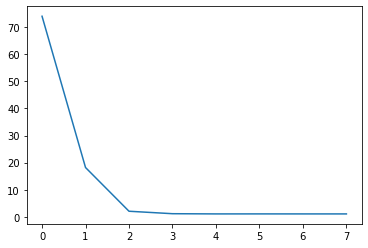

Epoch 1/50
4/4 - 3s - loss: 73.8700 - accuracy: 0.5190 - auc_22: 0.6573 - val_loss: 24.3975 - val_accuracy: 0.4286 - val_auc_22: 0.5730 - 3s/epoch - 743ms/step
Epoch 2/50
4/4 - 1s - loss: 19.8680 - accuracy: 0.4852 - auc_22: 0.6208 - val_loss: 7.4271 - val_accuracy: 0.5882 - val_auc_22: 0.7085 - 623ms/epoch - 156ms/step
Epoch 3/50
4/4 - 1s - loss: 6.9819 - accuracy: 0.5612 - auc_22: 0.7171 - val_loss: 1.9029 - val_accuracy: 0.5378 - val_auc_22: 0.7700 - 616ms/epoch - 154ms/step
Epoch 4/50
4/4 - 1s - loss: 3.1273 - accuracy: 0.5359 - auc_22: 0.7592 - val_loss: 1.4019 - val_accuracy: 0.5966 - val_auc_22: 0.8109 - 620ms/epoch - 155ms/step
Epoch 5/50
4/4 - 1s - loss: 2.1572 - accuracy: 0.6203 - auc_22: 0.8173 - val_loss: 0.9942 - val_accuracy: 0.5126 - val_auc_22: 0.7787 - 608ms/epoch - 152ms/step
Epoch 6/50
4/4 - 1s - loss: 1.7491 - accuracy: 0.6160 - auc_22: 0.8108 - val_loss: 0.9005 - val_accuracy: 0.5126 - val_auc_22: 0.7863 - 615ms/epoch - 154ms/step
Epoch 7/50
4/4 - 1s - loss: 1.5289

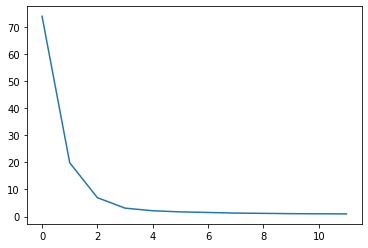

Epoch 1/50
4/4 - 3s - loss: 342.1478 - accuracy: 0.5000 - auc_23: 0.6239 - val_loss: 42.2357 - val_accuracy: 0.6949 - val_auc_23: 0.7712 - 3s/epoch - 838ms/step
Epoch 2/50
4/4 - 1s - loss: 41.1230 - accuracy: 0.5252 - auc_23: 0.6401 - val_loss: 8.6429 - val_accuracy: 0.6949 - val_auc_23: 0.7712 - 619ms/epoch - 155ms/step
Epoch 3/50
4/4 - 1s - loss: 5.6577 - accuracy: 0.5672 - auc_23: 0.7099 - val_loss: 7.5512 - val_accuracy: 0.2881 - val_auc_23: 0.4631 - 609ms/epoch - 152ms/step
Epoch 4/50
4/4 - 1s - loss: 3.4287 - accuracy: 0.5798 - auc_23: 0.6875 - val_loss: 4.1606 - val_accuracy: 0.2797 - val_auc_23: 0.5962 - 616ms/epoch - 154ms/step
Epoch 5/50
4/4 - 1s - loss: 2.7440 - accuracy: 0.4328 - auc_23: 0.6682 - val_loss: 2.8397 - val_accuracy: 0.6864 - val_auc_23: 0.8038 - 609ms/epoch - 152ms/step
Epoch 6/50
4/4 - 1s - loss: 2.1975 - accuracy: 0.6050 - auc_23: 0.7702 - val_loss: 3.6328 - val_accuracy: 0.3051 - val_auc_23: 0.6261 - 614ms/epoch - 154ms/step
Epoch 7/50
4/4 - 1s - loss: 2.020

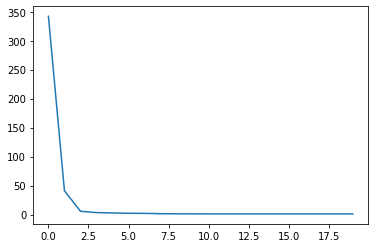

In [38]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    early_fusion_model = get_convLSTM_model(n_features, n_length, n_outputs)
    history = train(early_fusion_model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [39]:
loss, accuracy, auc = early_fusion_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 56.790%

AUC: 0.7584


## 2. Late Fusion - Fusion is performed at decision level "pre-training"

I consider late fusion by integrating outputs of individual trained classifiers (one per modality, same output label as the label at the end). Each ensemble member provides prediction scores that are aggregated to train a meta-learner (stacking ensemble). The ensemble is in charge of producing
the final classification. 

Fusion mechanisms/schemes used:

- (Unweighted) Majority voting. If the combination has a tie, we use the class probability (confidence score) to break the tie.

- Weighted voting

- Weighted sum

A drawback with the ensemble approach is that I only work with two modalities, so there's no ensemble if one modality is missing. It would have been more interesting with 3+ modalities. Additionally, I can't use models that require different input shapes (=slightly limiting).

### 2.1 Pain area prediction

### 2.2 Pain level prediction

## 3. Results

In [40]:
def show_results(first, last):
    plt.rcParams['figure.figsize'] = (8,8)
    x = np.arange(len(model_names[first:last]))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, accuracies[first:last], width, label='Accuracy')
    rects2 = ax.bar(x + width/2, aucs[first:last], width, label='AUC * 100')

    ax.set_ylim(0, 100)
    ax.set_xticks(x, model_names[first:last])
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

### Early fusion - Pain area prediction 

CNN+LSTM vs Convolutional LSTM

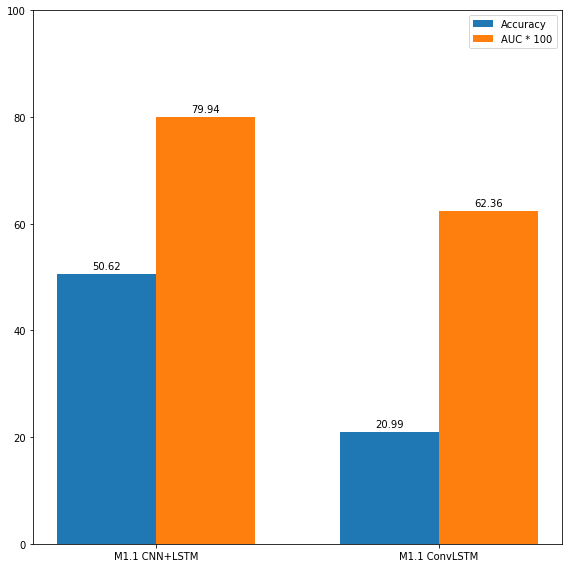

In [41]:
show_results(0, 2)

### Early fusion - Pain level prediction 

CNN+LSTM vs Convolutional LSTM

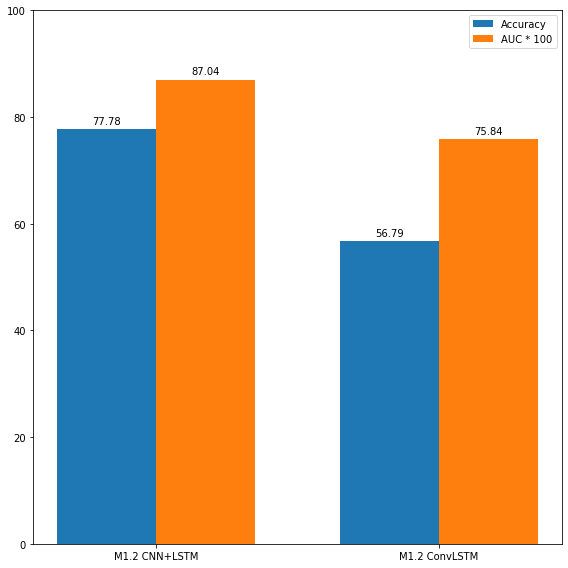

In [42]:
show_results(2, 4)